In [ ]:
!pip install tensorflow
!pip install pillow
!pip install matplotlib
!pip install opencv-python
!pip install seaborn
!pip install scikit-learn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import PIL
import random

from keras.layers.pooling import GlobalAveragePooling2D

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [2]:
data_dir = pathlib.Path('FoodImages')

In [3]:
batch_size = 32 #number of samples per one time
img_height = 224 #size of image
img_width = 224
imagesize = (224, 224)

In [4]:
#count images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1602


In [5]:
#Filter out corrupted images
num_skipped = 0
for folder_name in ('Burger', 'ClearSoup', 'Congee', 'FriedRice', 'GuayTeow', 'KaengSom', 'KhaoManGai', 'KhaoSoi', 'Larb', 'Massaman', 'PadKrapow', 'PadSeeEw', 'PadThai', 'SomTum', 'Spaghetti', 'Steak', 'ThaiGreenCurry', 'TomYumKung'):
    folder_path = os.path.join("FoodImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1653 files belonging to 18 classes.
Using 1323 files for training.


2021-12-07 16:44:21.540380: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1653 files belonging to 18 classes.
Using 330 files for validation.


In [8]:
class_names = train_ds.class_names

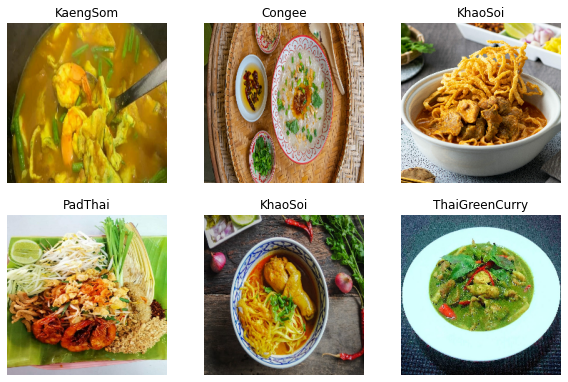

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 9
Number of test batches: 2


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

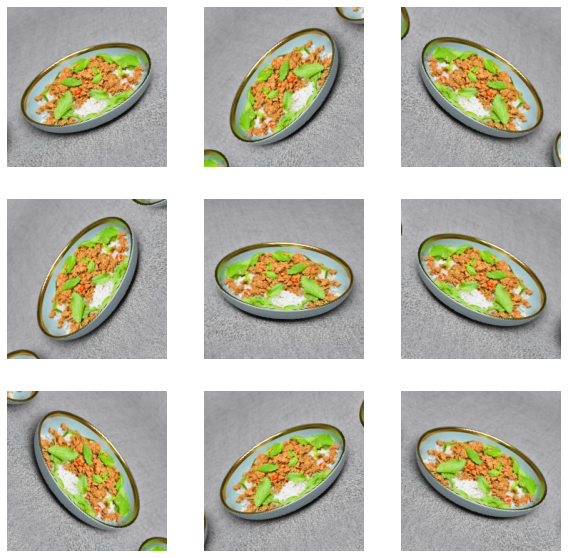

In [14]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [16]:
Xception_model = Sequential()

In [17]:
IMG_SHAPE = imagesize + (3,)
print(imagesize)
print(IMG_SHAPE)

(224, 224)
(224, 224, 3)


In [18]:
base_model = tf.keras.applications.Xception(
    include_top=False, weights='imagenet', input_shape = IMG_SHAPE, pooling = 'avg', classes=18,
)

In [19]:
for layer in base_model.layers:
        layer.trainable=False

In [20]:
Xception_model.add(base_model)

In [21]:
Xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,480
Trainable params: 0
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
inputs = Xception_model.input

#x = tf.keras.layers.GlobalAveragePooling2D()
x = tf.keras.layers.Dense(128, activation='relu')(Xception_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(18, activation='softmax')(x)

Xception_model = tf.keras.Model(inputs, outputs)

In [23]:
Xception_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 18)                2322      
                                                                 
Total params: 21,142,586
Trainable params: 281,106
Non-trainable params: 20,861,480
_________________________________________________________________


In [24]:
#Xception_model.add(Flatten())
#Xception_model.add(GlobalAveragePooling2D())
#Xception_model.add(Dense(18, activation='softmax'))

In [25]:
#tf.keras.losses.CategoricalCrossentropy()
#tf.keras.losses.SparseCategoricalCrossentropy()
Xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [26]:
initial_epochs = 1
history = Xception_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=initial_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights = True
        )
    ]
)

42/42 [==============================] - 158s 4s/step - loss: 6.1374 - accuracy: 0.0711 - val_loss: 3.9464 - val_accuracy: 0.1128


In [27]:
results = Xception_model.evaluate(test_ds, verbose = 0)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))

Test Accuracy: 7.81%


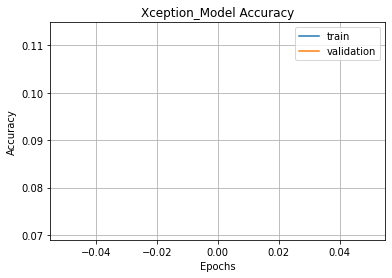

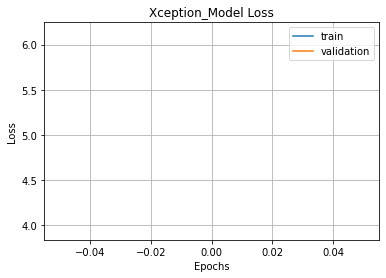

In [28]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Xception_Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Xception_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
#fine_tune_at = 100
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
Xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001/10),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
Xception_model.summary()

In [ ]:
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = Xception_model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights = True
        )
    ]
)

In [ ]:
results_fine = Xception_model.evaluate(test_ds, verbose = 0)
print('Test Accuracy: {:.2f}%'.format(results_fine[1]*100))

In [ ]:
fig3 = plt.gcf()
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig4 = plt.gcf()
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [29]:
#for confusion matrix
pred = np.argmax(Xception_model.predict(test_ds), axis = 1)

In [30]:
pred

array([13,  7,  5,  9,  7, 10, 13, 14,  6, 16, 16, 11, 16, 11, 17,  9, 10,
        1,  0,  6, 10, 12, 15, 13,  2, 17, 17,  8, 11,  2,  9, 17, 13, 15,
       16, 15, 17,  3, 13, 17,  2, 13,  1,  3,  5,  1, 17,  8, 15,  1, 13,
        6, 10,  8, 16,  2, 13, 14, 14, 13,  7, 17,  1, 14])

In [31]:
true_categories = tf.concat([y
   for x, y in test_ds
], axis = 0)

In [32]:
true_categories

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([13,  4, 11,  6,  4, 15, 13,  6, 15, 14, 15, 16,  8,  4, 10, 12, 10,
       14, 11,  9,  8,  7, 15,  5,  0, 12, 10,  8,  7,  9, 13,  5,  6, 17,
        8,  6,  2,  5,  2, 14,  1, 16,  0, 10, 15, 16, 15,  2,  1, 11, 13,
        4,  2,  7, 16, 15,  1, 15, 11, 11,  5, 10, 16,  4], dtype=int32)>

In [33]:
#confusion matrix
cm = confusion_matrix(true_categories, pred)
clr = classification_report(true_categories, pred)

/Users/mix/Desktop/CarelifyAI/carelifyai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mix/Desktop/CarelifyAI/carelifyai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mix/Desktop/CarelifyAI/carelifyai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

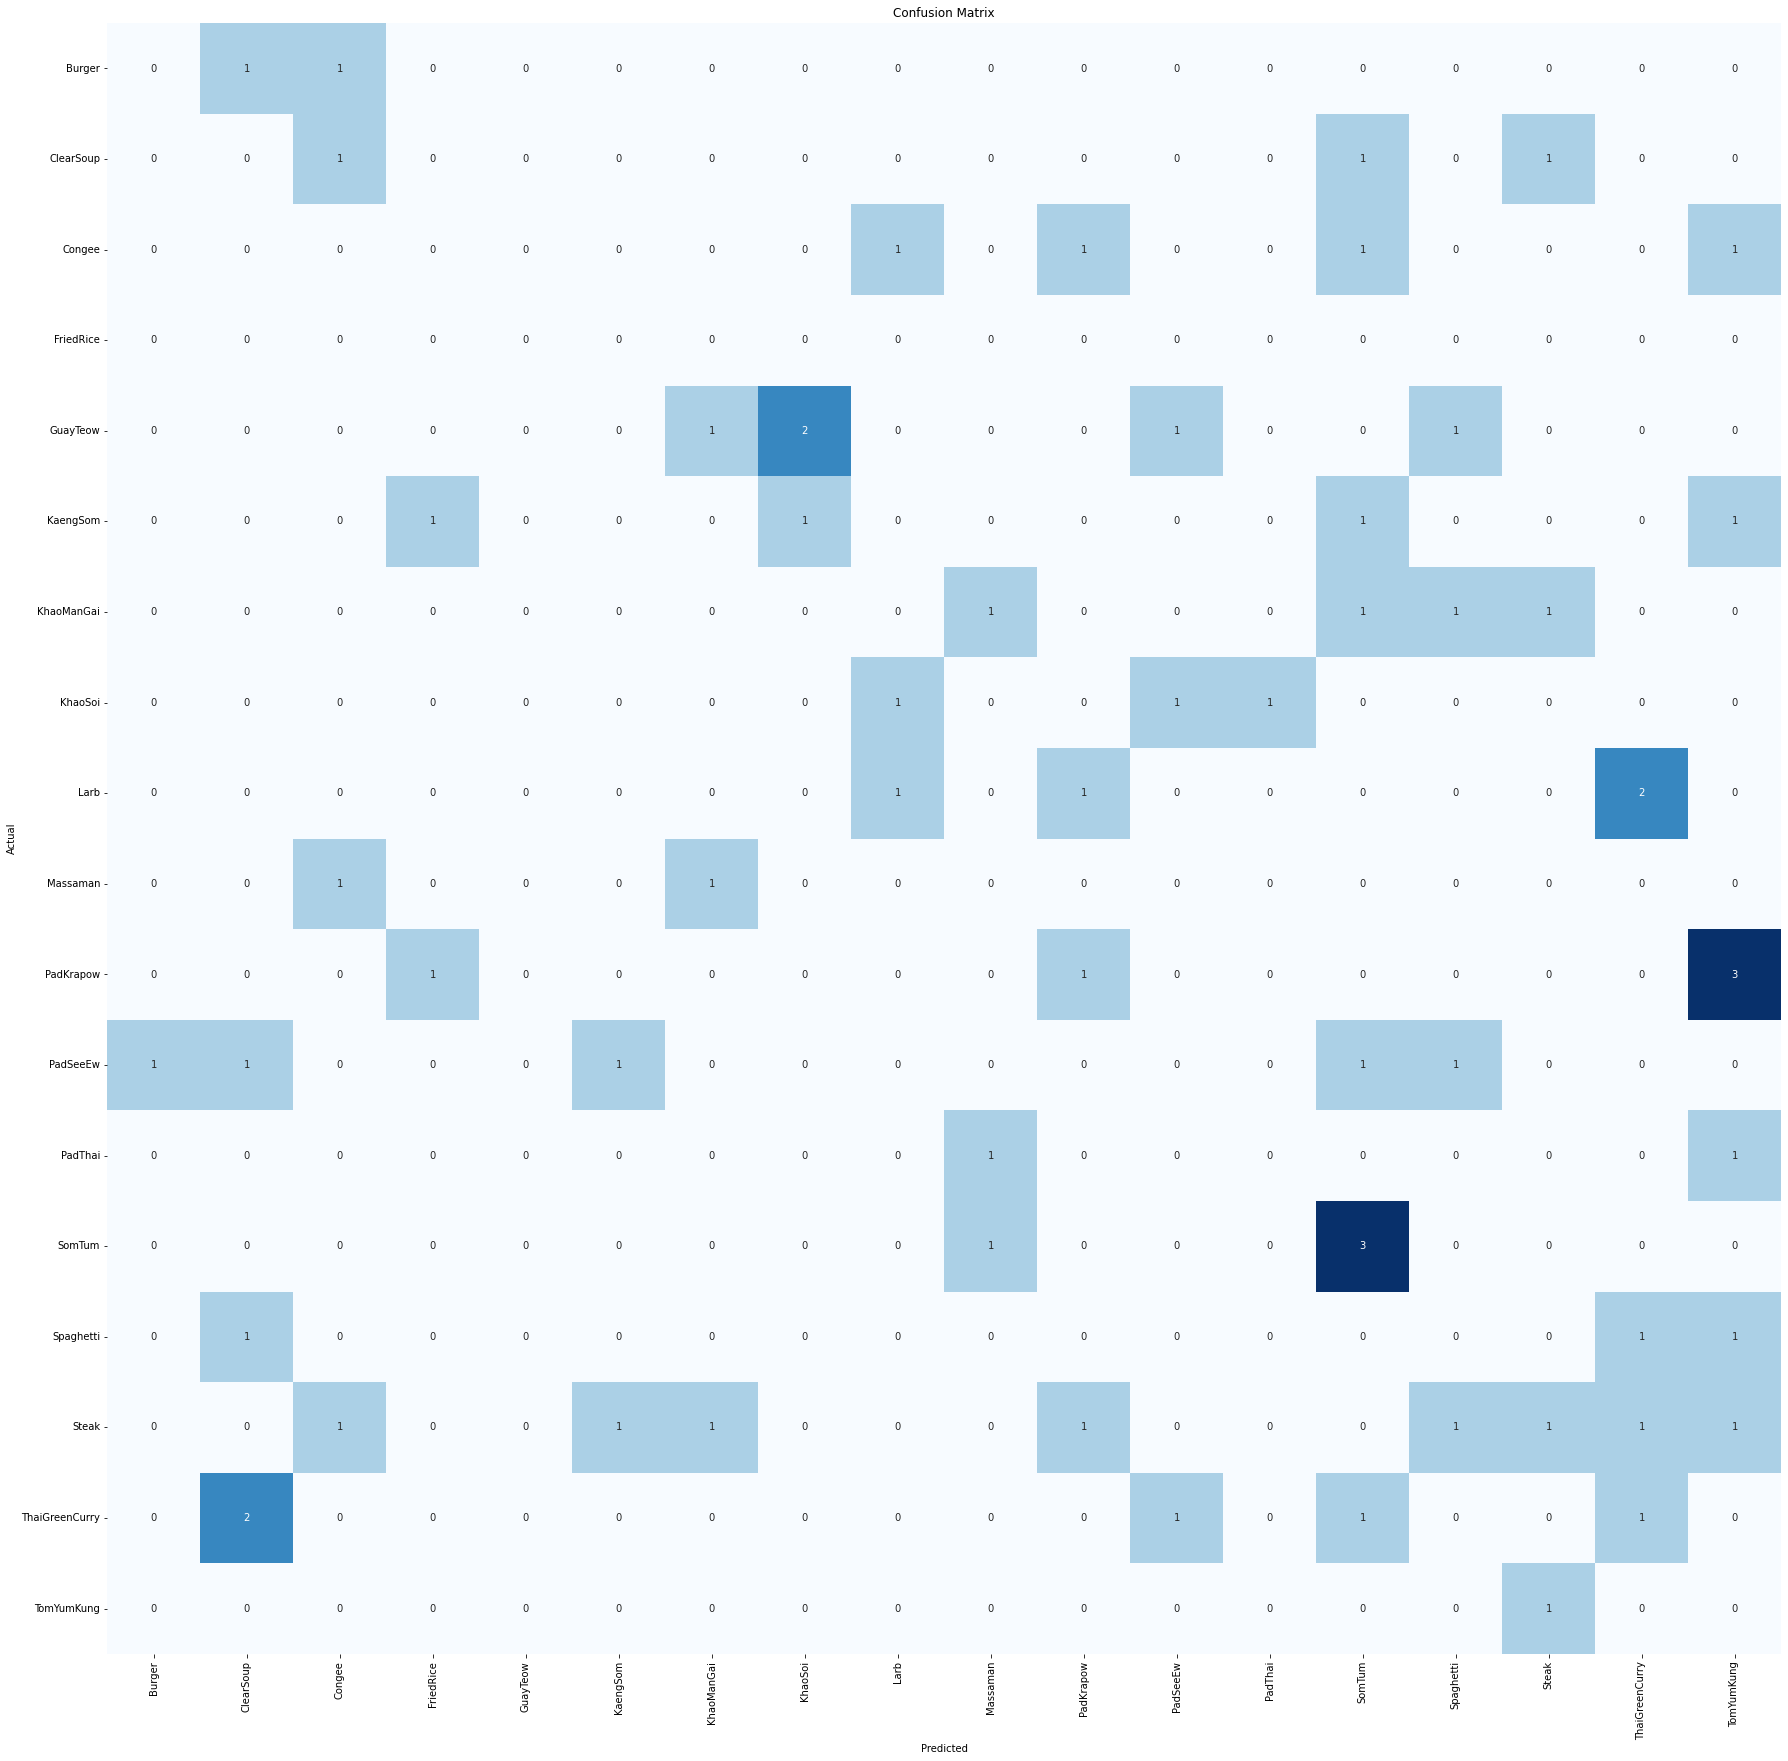

In [34]:
plt.figure(figsize = (30, 30))
sns.heatmap(cm, annot = True, fmt = 'g', vmin = 0, cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(18) + 0.5, labels = class_names, rotation = 90)
plt.yticks(ticks = np.arange(18) + 0.5, labels = class_names, rotation = 0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
print('Classification Report:\n-----------------------------------\n', clr)

Classification Report:
-----------------------------------
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.33      0.25      0.29         4
           9       0.00      0.00      0.00         2
          10       0.25      0.20      0.22         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         2
          13       0.33      0.75      0.46         4
          14       0.00      0.00      0.00         3
          15       0.25      0.12      0.17         8
          16       0.

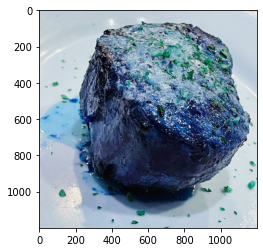

In [36]:
image=cv2.imread('Steak111.jpg')
plt.imshow(image)
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [37]:
# for sentence output
pred = Xception_model.predict(image)

In [38]:
pred

array([[0.02415631, 0.01940957, 0.00241608, 0.00694645, 0.01101123,
        0.00065343, 0.05384842, 0.05975524, 0.0016962 , 0.00304614,
        0.04351999, 0.4446391 , 0.00113278, 0.12371229, 0.00449921,
        0.03256626, 0.1062052 , 0.06078614]], dtype=float32)

In [39]:
sorted_index_array = np.argsort(pred)
sorted_index_array

array([[ 5, 12,  8,  2,  9, 14,  3,  4,  1,  0, 15, 10,  6,  7, 17, 16,
        13, 11]])

In [40]:
test = sorted_index_array[0][::-1]
test

array([11, 13, 16, 17,  7,  6, 10, 15,  0,  1,  4,  3, 14,  9,  2,  8, 12,
        5])

In [41]:
output_class0 = class_names[test[0]]
output_class1 = class_names[test[1]]
output_class2 = class_names[test[2]]
print("The predicted class1 is", output_class0)
print("The predicted class2 is", output_class1)
print("The predicted class3 is", output_class2)

The predicted class1 is PadSeeEw
The predicted class2 is SomTum
The predicted class3 is ThaiGreenCurry


In [42]:
output_classmax=class_names[np.argmax(pred)]
print("The predicted class is", output_classmax)

The predicted class is PadSeeEw


In [ ]:
model_dir=os.getcwd()+"//model//fooddetect_model(Xception, epochs = 6)"
Xception_model.save(model_dir+".h5")